# Experimentation with `FNO` operator on CUDA

In this notebook there are some experiments with the `FNO` operator. 

The experiments:
- ☑ 1. Test change of modes in the `FNO` operator
- ☒ 2. Change training with different number of data points
- ☒ 3. Test different resolution of the training data
- ☒ 4. Make comparison with the differnt tranings



In [21]:
!python generate_NS_data.py --resolution 64 --sample=20 --visc=1e-3
# !python generate_NS_data.py --resolution 512 --sample=20 --visc=1e-5

Using device: cuda
GPU: Tesla V100-PCIE-32GB
GPU Memory: 34.1 GB

Generating 20 samples at 64x64 resolution
Parameters: visc=0.001, T=20.0, steps=20

Generating: 100%|█████████████████████████████████| 4/4 [05:10<00:00, 77.71s/it]

✓ Data generation complete! Total time: 310.8 seconds
  Average time per batch: 77.71 seconds

Saving to data/ns_64x64_20_v1e-03.mat...
✓ File saved successfully!

Data shapes:
  Initial conditions (a): torch.Size([20, 64, 64]) - 20 samples at 64x64
  Solutions (u): torch.Size([20, 64, 64, 20]) - 20 samples, 64x64, 20 time steps
  Time points (t): torch.Size([20])

File size: 6.6 MB


## Libraries


In [3]:
# Setup paths to import modules
import sys
import os

# Add parent directory to path
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

print(f"Added {parent_dir} to sys.path")

Added /scratch/kl4747/Fourier-Neural-Operator-main to sys.path


In [4]:
# Import FNO model from PyTorch implementation
from FNO.PyTorch.fno import FNO

# Import loss function
from losses.lploss import LpLoss

# Import training utilities
from training.train import train_model

# Import data utilities - NSData provides unified data handling
from utilities.utils import MatlabFileReader, NSData

# Standard libraries
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import timeit

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU available, using CPU")

Using device: cuda
GPU 0: Tesla V100-PCIE-32GB


In [5]:
# Create a wrapper for FNO to match the expected FNO2DTime interface
class FNO2DTime(nn.Module):
    """
    Wrapper for FNO that matches the expected interface for 2D+time problems.
    This is for the Navier-Stokes equation with time evolution.
    
    Input:  [batch, 10, H, W] - 10 input time steps as channels
    Output: [batch, 10, H, W] - 10 output time steps as channels
    """
    def __init__(self, modes=12, width=32, layers=4, **kwargs):
        super(FNO2DTime, self).__init__()
        
        # The input is [batch, channels, x, y] where channels = time steps
        # For Navier-Stokes: input is 10 time steps, output is 10 time steps
        # Use pop() to remove from kwargs to avoid duplicate argument error
        in_channels = kwargs.pop('in_channels', 10)  # Default: 10 input time steps
        
        # Output is the next 10 time steps
        out_channels = kwargs.pop('out_channels', 10)  # Default: 10 output time steps
        
        # Create the FNO model
        # modes for 2D: [modes_x, modes_y]
        if isinstance(modes, int):
            modes_list = [modes, modes]
        else:
            modes_list = modes
            
        self.fno = FNO(
            modes=modes_list,
            num_fourier_layers=layers,
            in_channels=in_channels,
            lifting_channels=width,
            projection_channels=width,
            out_channels=out_channels,
            mid_channels=width,
            activation=nn.GELU(),
            **kwargs
        )
    
    def forward(self, x):
        return self.fno(x)
    
    def cuda(self):
        return self.to(device)


def prepare_ns_data(data, t_in=10, batch_size=50, shuffle=True):
    """
    Prepare Navier-Stokes data for FNO training.
    
    Converts data from [N, H, W, T] to [N, T, H, W] format and creates DataLoader.
    
    Args:
        data: Tensor of shape [N, H, W, T] where T >= t_in * 2
        t_in: Number of input time steps (default: 10)
        batch_size: Batch size for DataLoader
        shuffle: Whether to shuffle data
        
    Returns:
        DataLoader with (input, output) pairs in [batch, t_in, H, W] format
    """
    # Convert from [N, H, W, T] to [N, T, H, W]
    input_data = data[:, :, :, :t_in].permute(0, 3, 1, 2)
    output_data = data[:, :, :, t_in:t_in*2].permute(0, 3, 1, 2)
    
    return torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(input_data, output_data),
        batch_size=batch_size, shuffle=shuffle
    )


def prepare_input(data, t_in=10):
    """
    Prepare input data for FNO prediction. 
    Converts data from [N, H, W, T] to [N, T, H, W] format.
    """
    return data[:, :, :, :t_in].permute(0, 3, 1, 2)


print("✓ FNO2DTime wrapper created successfully!")
print("✓ prepare_ns_data helper function created!")
print("✓ prepare_input helper function created!")

✓ FNO2DTime wrapper created successfully!
✓ prepare_ns_data helper function created!
✓ prepare_input helper function created!


## Data

In [6]:
# Load data using NSData for unified handling
# NSData automatically converts [N, H, W, T] -> [N, T, H, W] format
math_path = "data/NavierStokes_V1e-5_N1200_T20.mat"
raw_data = MatlabFileReader(math_path, device=device, to_tensor=True).read_file("u")

# Create NSData object - handles all format conversions automatically
ns_data = NSData(raw_data, t_in=10, t_out=10, device=device)

# Split into train/test
train_ns, test_ns = ns_data.split(train_size=1000)

print(f"Full data: {ns_data}")
print(f"Train data: {train_ns}")
print(f"Test data: {test_ns}")

Full data: NSData(samples=1200, times=20, size=64x64, device=cuda)
Train data: NSData(samples=1000, times=20, size=64x64, device=cuda)
Test data: NSData(samples=200, times=20, size=64x64, device=cuda)


## 1. Test change of modes in the `FNO` operator

In [5]:
# Create an instance of the model (uses default in_channels=10, out_channels=10)
fno_model = FNO2DTime(modes=4).cuda()

In [6]:
# Create data loaders using NSData (already in correct format!)
train_loader = train_ns.get_dataloader(batch_size=50, shuffle=True)
test_loader = test_ns.get_dataloader(batch_size=50, shuffle=True)

print(f"Input shape: {train_ns.get_input().shape}")
print(f"Output shape: {train_ns.get_output().shape}")

Input shape: torch.Size([1000, 10, 64, 64])
Output shape: torch.Size([1000, 10, 64, 64])


In [7]:
# Create an instance of the loss function
loss_fn = LpLoss()

In [8]:
# Train the model using the standard train_model function
# Now works with [batch, channels, H, W] format
loss1, mse1 = train_model(model=fno_model,
                          train_dataloader=train_loader,
                          test_dataloader=test_loader,
                          epochs=100,
                          device=device)

print(f"\nTraining completed!")
print(f"Final train loss: {loss1['train'].iloc[-1]:.6f}, test loss: {loss1['test'].iloc[-1]:.6f}")
print(f"Final train MSE: {mse1['train'].iloc[-1]:.6f}, test MSE: {mse1['test'].iloc[-1]:.6f}")

100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


Training completed!
Final train loss: 0.208086, test loss: 0.212287
Final train MSE: 0.096824, test MSE: 0.099962


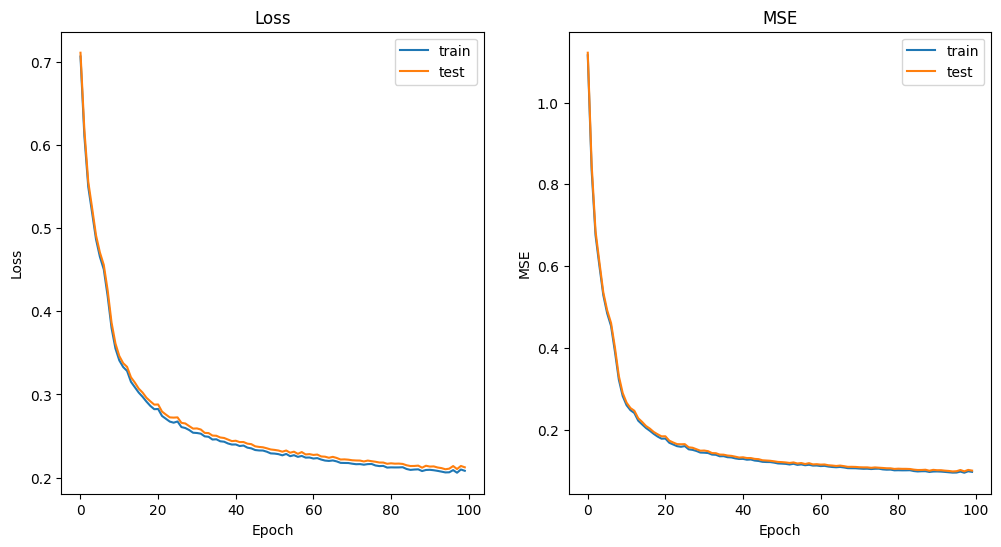

In [9]:
# Plot the loss and mse
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(loss1, label=['train', 'test'])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(mse1, label=['train', 'test'])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('MSE')
ax[1].set_title('MSE')
ax[1].legend()
plt.show()

In [ ]:
# Save the model
torch.save(fno_model, "data/FNO_2D_Time_100epochs_NavierStokes_4modes.pt")

## 2. Change training with different number of data points

In [11]:
# Instantiate a new model (uses default in_channels=10, out_channels=10)
fno_model_2 = FNO2DTime().cuda()

In [13]:
# Prepare the data, remember, t = [0, 10] is for input(u), t = [10, 20] is for output(a)
train_data = raw_data[:500, :, :, :].cuda()
eval_data = raw_data[500:600, :, :, :].cuda()

# Create data loaders (helper handles [N,H,W,T] -> [N,T,H,W] conversion)
train_loader = prepare_ns_data(train_data, batch_size=50, shuffle=True)
eval_loader = prepare_ns_data(eval_data, batch_size=50, shuffle=True)

In [14]:
# Create an instance of the loss function
loss_fn = LpLoss()

In [15]:
# Train the model
loss2, mse2 = train_model(model=fno_model_2,
                        train_dataloader=train_loader,
                        test_dataloader=eval_loader,
                        epochs=100,
                        device=device,)

100%|██████████| 100/100 [00:36<00:00,  2.72it/s]


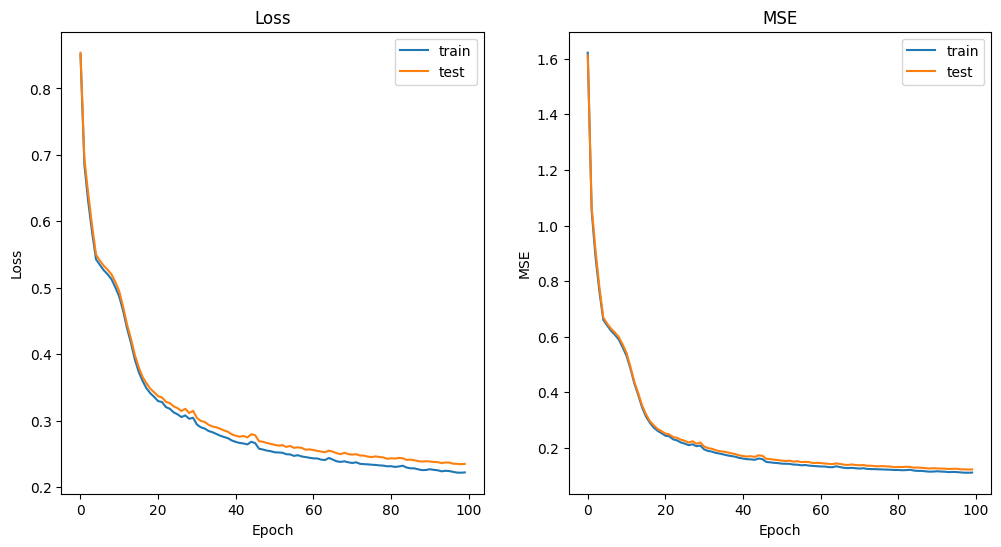

In [16]:
# Plot the loss and mse
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(loss2, label=['train', 'test'])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(mse2, label=['train', 'test'])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('MSE')
ax[1].set_title('MSE')
ax[1].legend()
plt.show()

In [ ]:
# Save the model
torch.save(fno_model_2, "data/FNO_2D_Time_100epochs_NavierStokes_500samples.pt")

## 3. Test different resolution of the training data

In [18]:
# Instantiate a new model (uses default in_channels=10, out_channels=10)
fno_model_3 = FNO2DTime().cuda()

In [19]:
# Prepare the data
train_data = raw_data[:1000, :, :, :].cuda()
test_data = raw_data[1000:, :, :, :].cuda()

# Change resolution of [, 64, 64, :] to [, 32, 32, :]
train_data = torch.nn.functional.interpolate(train_data.permute(0, 3, 1, 2), size=(32, 32)).permute(0, 2, 3, 1)
# test_data = torch.nn.functional.interpolate(test_data.permute(0, 3, 1, 2), size=(32, 32)).permute(0, 2, 3, 1)

# Create data loaders (helper handles [N,H,W,T] -> [N,T,H,W] conversion)
train_loader = prepare_ns_data(train_data, batch_size=50, shuffle=True)
test_loader = prepare_ns_data(test_data, batch_size=50, shuffle=True)

In [20]:
# Create an instance of the loss function
loss_fn = LpLoss()

In [21]:
# Train the model
loss3, mse3 = train_model(model=fno_model_3,
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        epochs=100,
                        device=device,)

100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


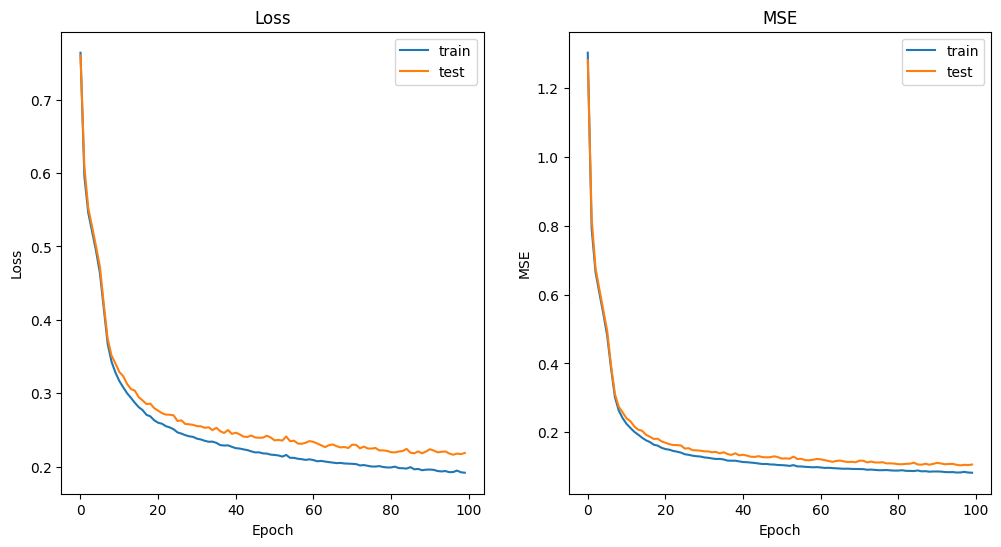

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(loss3, label=['train', 'test'])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(mse3, label=['train', 'test'])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('MSE')
ax[1].set_title('MSE')
ax[1].legend()
plt.show()

In [ ]:
# Save the model
torch.save(fno_model_3, "data/FNO_2D_Time_100epochs_NavierStokes_32x32.pt")

In [24]:
# Instantiate a new model (uses default in_channels=10, out_channels=10)
fno_model_4 = FNO2DTime().cuda()

In [25]:
# Prepare the data
train_data = raw_data[:1000, :, :, :].cuda()
test_data = raw_data[1000:, :, :, :].cuda()

# Change resolution of [, 64, 64, :] to [, 16, 16, :]
train_data = torch.nn.functional.interpolate(train_data.permute(0, 3, 1, 2), size=(16, 16)).permute(0, 2, 3, 1)
# test_data = torch.nn.functional.interpolate(test_data.permute(0, 3, 1, 2), size=(16, 16)).permute(0, 2, 3, 1)

print(train_data.shape)
print(test_data.shape)

# Create data loaders (helper handles [N,H,W,T] -> [N,T,H,W] conversion)
train_loader = prepare_ns_data(train_data, batch_size=50, shuffle=True)
test_loader = prepare_ns_data(test_data, batch_size=50, shuffle=True)

torch.Size([1000, 16, 16, 20])
torch.Size([200, 64, 64, 20])


In [26]:
# Train the model
loss4, mse4 = train_model(model=fno_model_4,
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        epochs=100,
                        device=device,)

100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


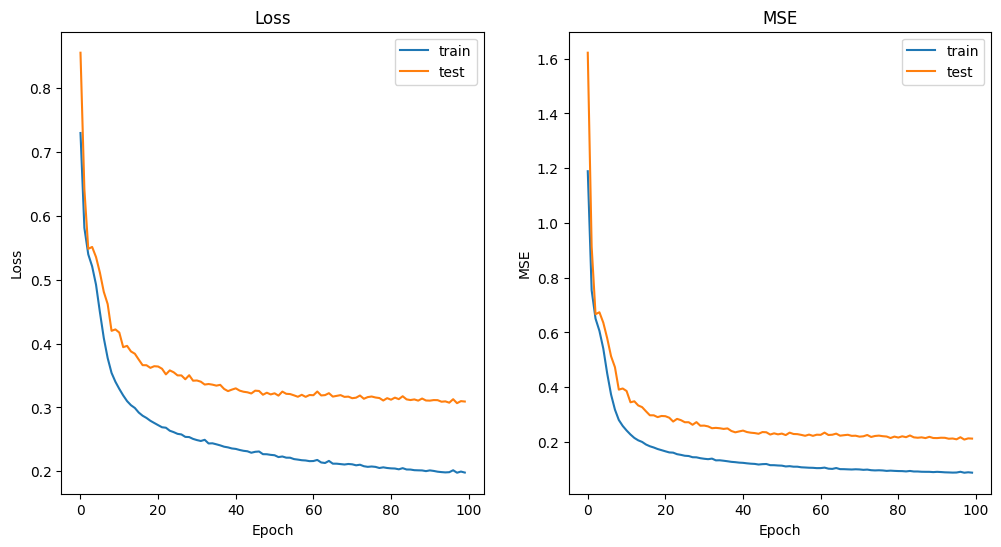

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(loss4, label=['train', 'test'])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(mse4, label=['train', 'test'])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('MSE')
ax[1].set_title('MSE')
ax[1].legend()
plt.show()

In [ ]:
# Save the model
torch.save(fno_model_3, "data/FNO_2D_Time_100epochs_NavierStokes_16x16.pt")

## 5. Baseline Model (Default Settings)

This is the baseline model with default settings:
- **Resolution**: 64x64 (original)
- **Modes**: 12 (default)
- **Training samples**: 1000
- **Epochs**: 100

This will be used for comparison with other experiments.

In [29]:
# Instantiate baseline model with default modes=12
fno_model_5 = FNO2DTime(modes=12).cuda()
print(f"Baseline model created with modes=12")

Baseline model created with modes=12


In [ ]:
# Prepare data (64x64 resolution, 1000 samples - same as experiment 1)
train_data = raw_data[:1000, :, :, :].cuda()
test_data = raw_data[1000:, :, :, :].cuda()

# Create data loaders
train_loader = prepare_ns_data(train_data, batch_size=50, shuffle=True)
test_loader = prepare_ns_data(test_data, batch_size=50, shuffle=True)

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Train data shape: torch.Size([1000, 64, 64, 20])
Test data shape: torch.Size([200, 64, 64, 20])


In [ ]:
# Train the baseline model
loss5, mse5 = train_model(model=fno_model_5,
                          train_dataloader=train_loader,
                          test_dataloader=test_loader,
                          epochs=100,
                          device=device)

100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


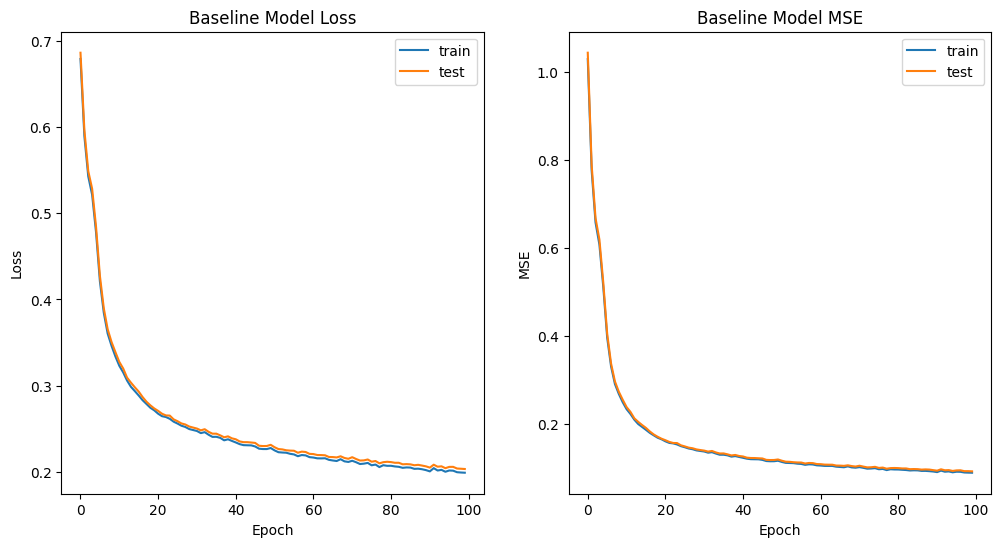

In [ ]:
# Plot the loss and mse
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(loss5, label=['train', 'test'])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Baseline Model Loss')
ax[0].legend()
ax[1].plot(mse5, label=['train', 'test'])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('MSE')
ax[1].set_title('Baseline Model MSE')
ax[1].legend()
plt.show()

In [ ]:
# Save the baseline model
torch.save(fno_model_5, "data/FNO_2D_Time_100epochs_NavierStokes_baseline.pt")

## Comparison with the different models

We will compare the different models with the following metrics:

- Mean squared error
- Mean absolute error

To compare the models we will make predictions with diferent data points, calculate the metrics and plot the results.

In [7]:
# Load data and Extract last 100 samples for testing
math_path = "data/NavierStokes_V1e-5_N1200_T20.mat"
raw_data = MatlabFileReader(math_path, device=device, to_tensor=True).read_file("u")
test_data = NSData(raw_data[1100:], device=device)

print(f"Comparison data: {test_data}")

Comparison data: NSData(samples=100, times=20, size=64x64, device=cuda)


In [ ]:
# Instance each model (weights_only=False needed for PyTorch 2.6+)
fno_model_1 = torch.load("data/FNO_2D_Time_100epochs_NavierStokes_4modes.pt", weights_only=False).cuda()      # modes=4
fno_model_2 = torch.load("data/FNO_2D_Time_100epochs_NavierStokes_500samples.pt", weights_only=False).cuda()  # 500 samples
fno_model_3 = torch.load("data/FNO_2D_Time_100epochs_NavierStokes_32x32.pt", weights_only=False).cuda()       # 32x32 resolution
fno_model_4 = torch.load("data/FNO_2D_Time_100epochs_NavierStokes_16x16.pt", weights_only=False).cuda()       # 16x16 resolution
fno_model_5 = torch.load("data/FNO_2D_Time_100epochs_NavierStokes_baseline.pt", weights_only=False).cuda()    # baseline (modes=12, 64x64, 1000 samples)

In [9]:
# Make predictions for each model using NSData
# test_data.get_input() returns data in [N, T, H, W] format
test_input = test_data.get_input()

with torch.no_grad():
    pred1 = fno_model_1(test_input)
    pred2 = fno_model_2(test_input)
    pred3 = fno_model_3(test_input)
    pred4 = fno_model_4(test_input)
    pred5 = fno_model_5(test_input)
    
print(f"Input shape: {test_input.shape}")
print(f"Predictions shape: {pred1.shape}")

Input shape: torch.Size([100, 10, 64, 64])
Predictions shape: torch.Size([100, 10, 64, 64])


In [10]:
# Count time of prediction
start = timeit.default_timer()
with torch.no_grad():
    pred1 = fno_model_1(test_input)  # test_input already prepared above
stop = timeit.default_timer()
print('Time: ', stop - start)

Time:  0.006348494440317154


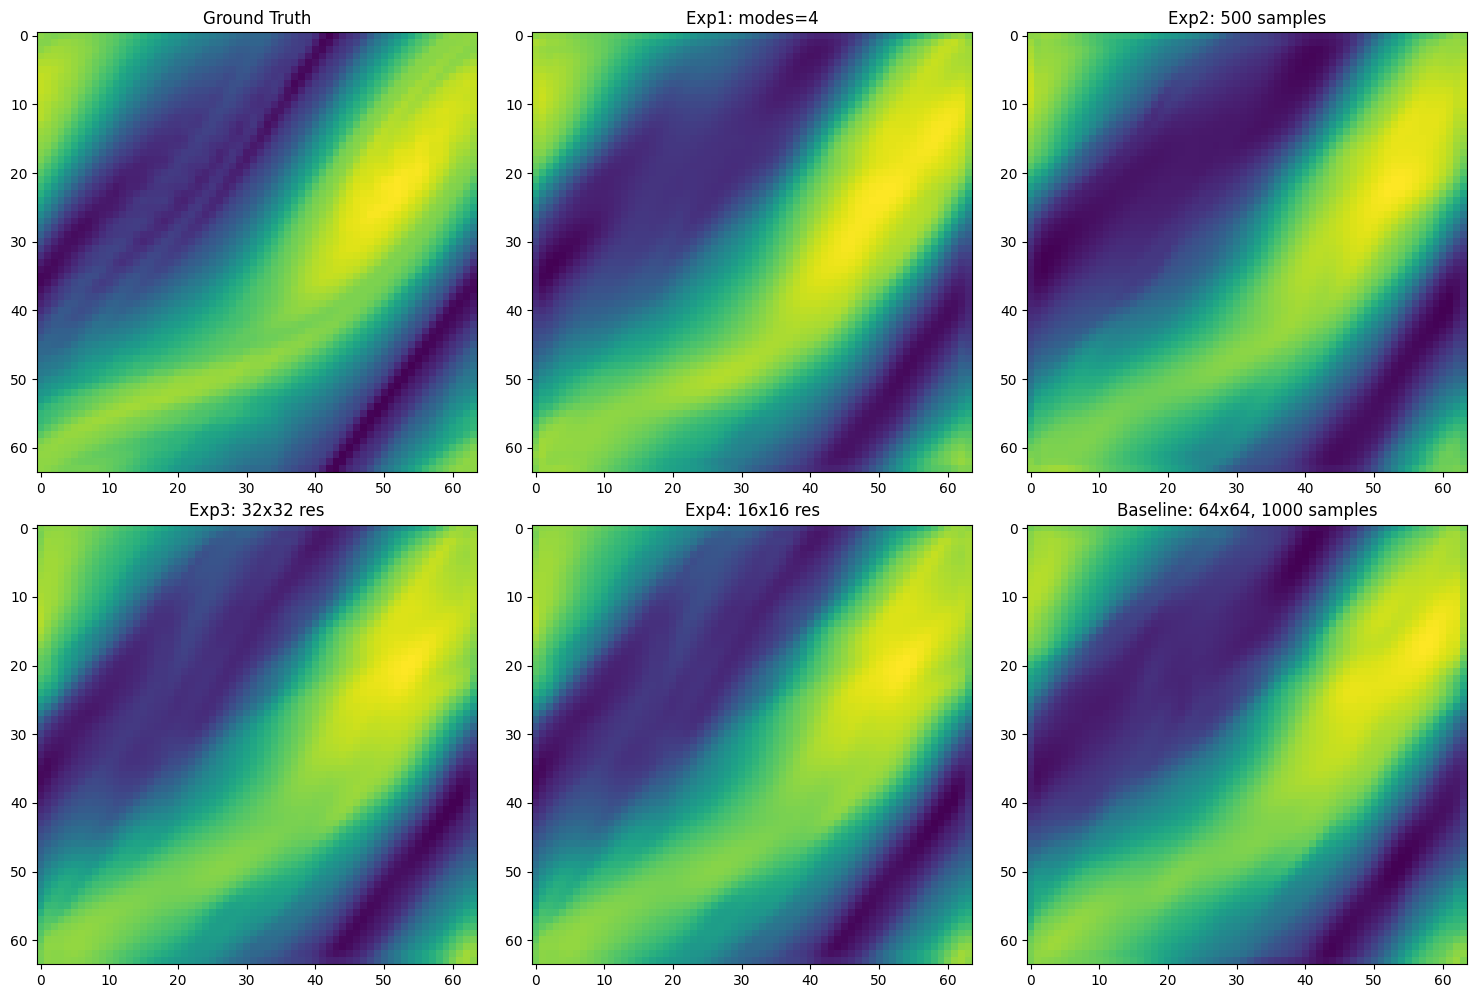

In [11]:
# Make plots comparing different experiments
# Using NSData: test_data.get_ground_truth(sample, time) for ground truth
# Predictions are in [N, T, H, W] format: pred[sample, time, :, :]
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0][0].imshow(test_data.get_ground_truth(0, 0).cpu().numpy())
ax[0][0].set_title("Ground Truth")
ax[0][1].imshow(pred1[0, 0, :, :].cpu().numpy())
ax[0][1].set_title("Exp1: modes=4")
ax[0][2].imshow(pred2[0, 0, :, :].cpu().numpy())
ax[0][2].set_title("Exp2: 500 samples")
ax[1][0].imshow(pred3[0, 0, :, :].cpu().numpy())
ax[1][0].set_title("Exp3: 32x32 res")
ax[1][1].imshow(pred4[0, 0, :, :].cpu().numpy())
ax[1][1].set_title("Exp4: 16x16 res")
ax[1][2].imshow(pred5[0, 0, :, :].cpu().numpy())
ax[1][2].set_title("Baseline: 64x64, 1000 samples")
plt.tight_layout()
plt.show()

Value range (GT/Pred): [-1.9249, 1.8647]
Error range: [-0.4804, 0.4804]


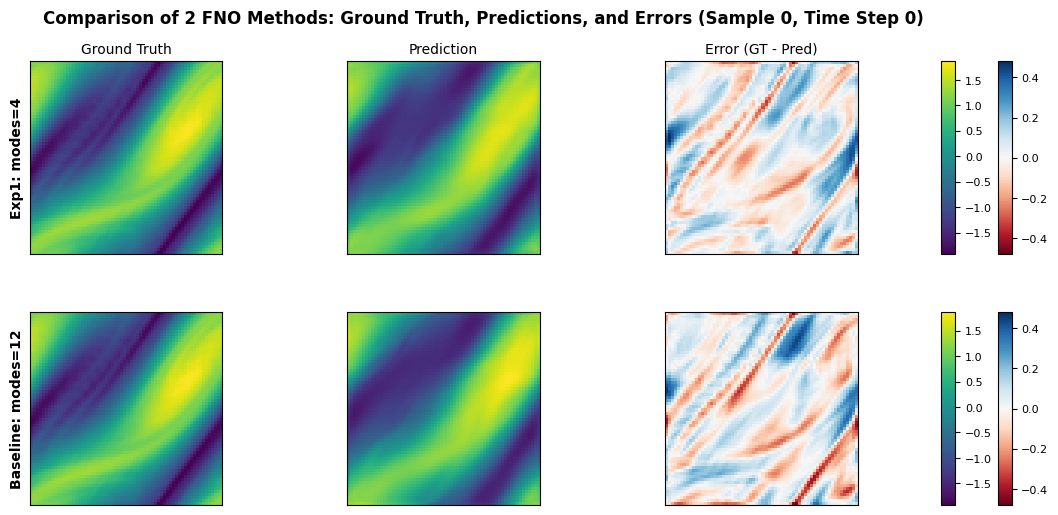


Error Statistics:
Exp1: modes=4             | MAE: 0.096543 | MSE: 0.015244 | Max: 0.480407
Baseline: modes=12        | MAE: 0.105912 | MSE: 0.018677 | Max: 0.466084


In [18]:
# Compare all methods with ground truth - Error visualization
# Each row has 2 colorbars: one for GT/Pred (shared), one for Error

gt = test_data.get_ground_truth(0, 0).cpu().numpy()

# Get all predictions
preds = [
    pred1[0, 0, :, :].cpu().numpy(),
    pred2[0, 0, :, :].cpu().numpy(),
    pred3[0, 0, :, :].cpu().numpy(),
    pred4[0, 0, :, :].cpu().numpy(),
    pred5[0, 0, :, :].cpu().numpy()
]

method_names = [
    "Exp1: modes=4",
    # "Exp2: 500 samples", 
    # "Exp3: 32x32 res",
    # "Exp4: 16x16 res",
    "Baseline: modes=12"
]

# Calculate all errors to find global min/max for consistent error colorbar
errors = [gt - pred for pred in preds]
all_errors = np.concatenate([e.flatten() for e in errors])
error_vmax = np.abs(all_errors).max()
error_vmin = -error_vmax  # Symmetric around zero for RdBu colormap

# Find global min/max for GT and predictions for consistent value colorbar
all_values = np.concatenate([gt.flatten()] + [pred.flatten() for pred in preds])
value_vmin = all_values.min()
value_vmax = all_values.max()

print(f"Value range (GT/Pred): [{value_vmin:.4f}, {value_vmax:.4f}]")
print(f"Error range: [{error_vmin:.4f}, {error_vmax:.4f}]")

# Create figure with GridSpec for better control
# Reduced figure size and adjusted spacing
fig = plt.figure(figsize=(11, 13))
import matplotlib.gridspec as gridspec

# Create grid: 5 rows, each row has 3 image columns + 2 colorbar columns
gs = gridspec.GridSpec(5, 5, figure=fig, 
                       width_ratios=[1, 1, 1, 0.05, 0.05],  # 3 images + 2 colorbars
                       wspace=0.25, hspace=0.3,
                       left=0.05, right=0.98, top=0.94, bottom=0.02)

for i, (pred, error, name) in enumerate(zip(preds, errors, method_names)):
    # Ground Truth
    ax_gt = fig.add_subplot(gs[i, 0])
    im_gt = ax_gt.imshow(gt, cmap='viridis', vmin=value_vmin, vmax=value_vmax)
    ax_gt.set_title(f"Ground Truth" if i == 0 else "", fontsize=10)
    ax_gt.set_ylabel(name, fontsize=10, fontweight='bold')
    ax_gt.set_xticks([])
    ax_gt.set_yticks([])
    
    # Prediction
    ax_pred = fig.add_subplot(gs[i, 1])
    im_pred = ax_pred.imshow(pred, cmap='viridis', vmin=value_vmin, vmax=value_vmax)
    ax_pred.set_title(f"Prediction" if i == 0 else "", fontsize=10)
    ax_pred.set_xticks([])
    ax_pred.set_yticks([])
    
    # Error
    ax_err = fig.add_subplot(gs[i, 2])
    im_err = ax_err.imshow(error, cmap='RdBu', vmin=error_vmin, vmax=error_vmax)
    ax_err.set_title(f"Error (GT - Pred)" if i == 0 else "", fontsize=10)
    ax_err.set_xticks([])
    ax_err.set_yticks([])
    
    # Colorbar for GT/Pred (shared)
    cax_value = fig.add_subplot(gs[i, 3])
    cbar_value = plt.colorbar(im_pred, cax=cax_value)
    cbar_value.ax.tick_params(labelsize=8)
    if i == 2:  # Middle row
        cbar_value.set_label('Value', fontsize=9, rotation=270, labelpad=15)
    
    # Colorbar for Error
    cax_error = fig.add_subplot(gs[i, 4])
    cbar_error = plt.colorbar(im_err, cax=cax_error)
    cbar_error.ax.tick_params(labelsize=8)
    if i == 2:  # Middle row
        cbar_error.set_label('Error', fontsize=9, rotation=270, labelpad=15)

plt.suptitle(f'Comparison of {len(method_names)} FNO Methods: Ground Truth, Predictions, and Errors (Sample 0, Time Step 0)', 
             fontsize=12, fontweight='bold')
plt.show()

# Print error statistics for each method
print("\n" + "="*60)
print("Error Statistics:")
print("="*60)
for name, error in zip(method_names, errors):
    mae = np.abs(error).mean()
    mse = (error**2).mean()
    max_err = np.abs(error).max()
    print(f"{name:25s} | MAE: {mae:.6f} | MSE: {mse:.6f} | Max: {max_err:.6f}")

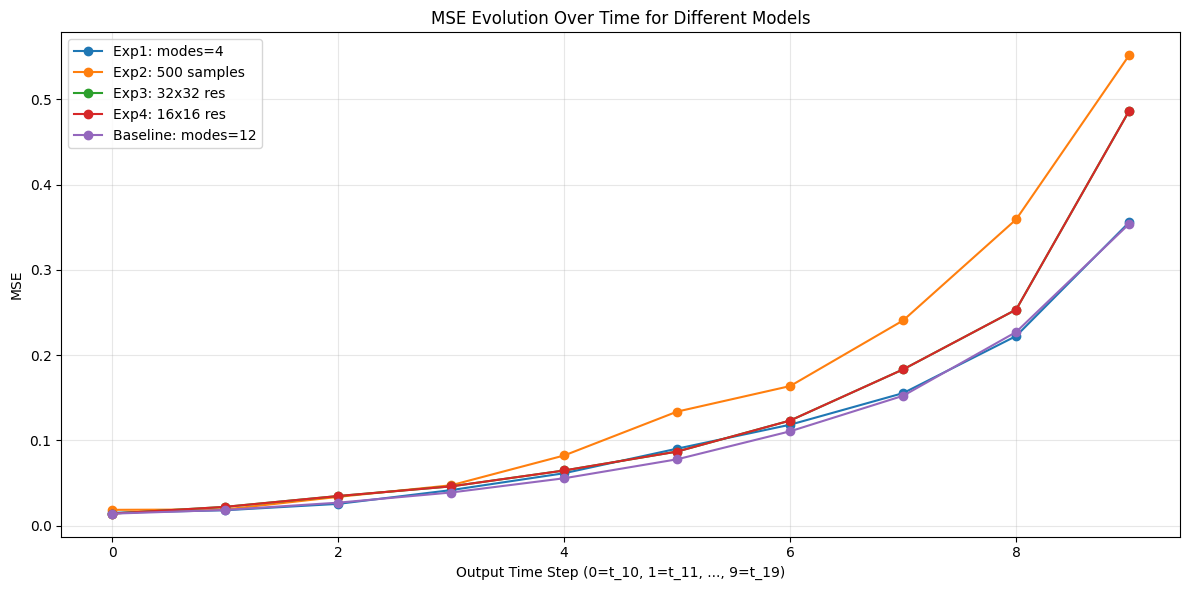

In [49]:
# Calculate the error over time using NSData
# test_data.get_ground_truth(sample, time) returns ground truth
# predictions are [N, T, H, W], prediction at time step i is pred[0, i, :, :]
error1, error2, error3, error4, error5 = [], [], [], [], []
for i in range(10):
    gt = test_data.get_ground_truth(0, i)
    error1.append(F.mse_loss(gt, pred1[0, i, :, :]).item())
    error2.append(F.mse_loss(gt, pred2[0, i, :, :]).item())
    error3.append(F.mse_loss(gt, pred3[0, i, :, :]).item())
    error4.append(F.mse_loss(gt, pred4[0, i, :, :]).item())
    error5.append(F.mse_loss(gt, pred5[0, i, :, :]).item())
    
# Plot the error evolution over time steps
# X-axis: output time steps (t=10, 11, ..., 19)
# Y-axis: MSE at each time step
fig = plt.figure(figsize=(12, 6))
plt.plot(error1, "o-", label="Exp1: modes=4")
plt.plot(error2, "o-", label="Exp2: 500 samples")
plt.plot(error3, "o-", label="Exp3: 32x32 res")
plt.plot(error4, "o-", label="Exp4: 16x16 res")
plt.plot(error5, "o-", label="Baseline: modes=12")
plt.xlabel("Output Time Step (0=t_10, 1=t_11, ..., 9=t_19)")
plt.ylabel("MSE")
plt.title("MSE Evolution Over Time for Different Models")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Test zero-shot learning: unseen data, same resolution, test on generalizability

In [22]:
# data_new = np.load("ns_512x512_20_v1e-03.npy")
data_new = MatlabFileReader("data/ns_64x64_20_v1e-03.mat", device='cpu', to_tensor=False).read_file("u")
data_new.shape

(20, 64, 64, 20)

In [23]:
# Convert numpy data to tensor and use prepare_input for correct format
# data_new is [N, H, W, T], need to convert to [N, T, H, W]
data_new_tensor = torch.tensor(data_new).cuda()
with torch.no_grad():
    pred_new = fno_model_5(prepare_input(data_new_tensor))

In [24]:
pred_new.shape

torch.Size([20, 10, 64, 64])

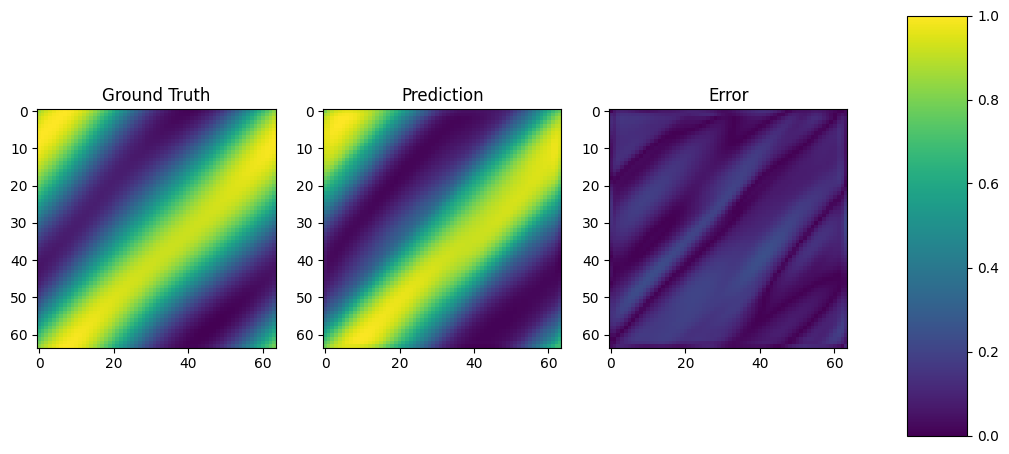

In [25]:
# Make animation with predictions
# pred_new is [N, T, H, W], data_new is [N, H, W, T]
import matplotlib.animation as animation

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(data_new[0, :, :, 10])
ax[0].set_title("Ground Truth")
ax[1].imshow(pred_new[0, 0, :, :].cpu().numpy())
ax[1].set_title("Prediction")
ax[2].imshow(data_new[0, :, :, 10] - pred_new[0, 0, :, :].cpu().numpy(), vmin=0, vmax=1)
ax[2].set_title("Error")

# Add colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(ax[2].imshow(data_new[0, :, :, 10] - pred_new[0, 0, :, :].cpu().numpy(), vmin=0, vmax=1), cax=cbar_ax)

def animate(i):
    ax[0].imshow(data_new[0, :, :, 10+i])
    ax[1].imshow(pred_new[0, i, :, :].cpu().numpy())
    ax[2].imshow(np.abs(data_new[0, :, :, 10+i] - pred_new[0, i, :, :].cpu().numpy()), vmin=0, vmax=1)
    
ani = animation.FuncAnimation(fig, animate, frames=10, interval=500)
ani.save("FNO_NavierStokes_forced_function.gif")

In [26]:
# Correct indexing: data_new[0, :, :, 10+i], pred_new[0, i, :, :]
data_new[0, :, :, 10], pred_new[0, 0, :, :].cpu().numpy()

(array([[0.8480429 , 0.9301748 , 1.0010573 , ..., 0.54507935, 0.6542229 ,
         0.75566304],
        [0.92578685, 0.9976275 , 1.0576236 , ..., 0.64850926, 0.7501112 ,
         0.842939  ],
        [0.9931055 , 1.054161  , 1.1029379 , ..., 0.74395555, 0.83704674,
         0.9204459 ],
        ...,
        [0.5601226 , 0.66843796, 0.7682546 , ..., 0.19948676, 0.32398266,
         0.44476846],
        [0.66423297, 0.7647711 , 0.85573745, ..., 0.31916004, 0.4398768 ,
         0.555441  ],
        [0.76056325, 0.8523186 , 0.93358266, ..., 0.43484902, 0.5504099 ,
         0.6594802 ]], dtype=float32),
 array([[0.841018  , 0.9910806 , 1.0902741 , ..., 0.550674  , 0.6620342 ,
         0.7319282 ],
        [1.0227389 , 1.0769444 , 1.1848966 , ..., 0.67840725, 0.7976475 ,
         0.8761846 ],
        [1.111274  , 1.1548698 , 1.2505182 , ..., 0.7948342 , 0.9140675 ,
         0.98166555],
        ...,
        [0.5648901 , 0.6717017 , 0.8175819 , ..., 0.04108305, 0.20744585,
         0.37584597

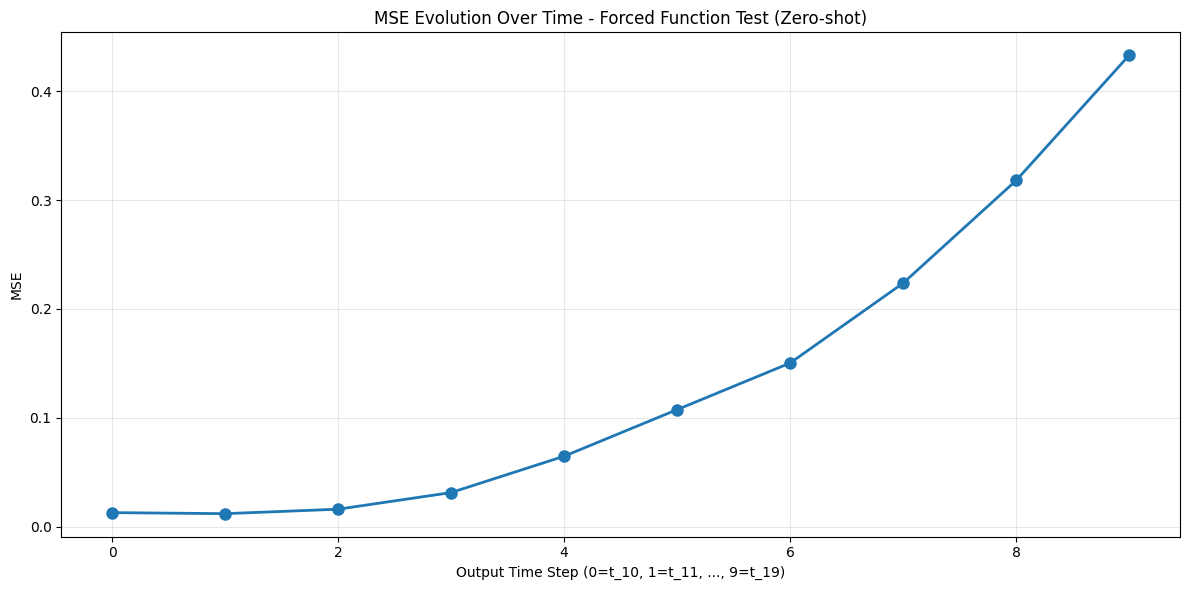

In [27]:
# Plot the error evolution over time
# pred_new is [N, T, H, W], data_new is [N, H, W, T]
error = []
for i in range(10):
    error.append(F.mse_loss(pred_new[0, i, :, :], torch.tensor(data_new[0, :, :, 10+i]).cuda()).item())
    
fig = plt.figure(figsize=(12, 6))
plt.plot(error, "o-", linewidth=2, markersize=8)
plt.xlabel("Output Time Step (0=t_10, 1=t_11, ..., 9=t_19)")
plt.ylabel("MSE")
plt.title("MSE Evolution Over Time - Forced Function Test (Zero-shot)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Test on super-resolution: seen data on low-resolution

In [ ]:
# data_new = np.load("ns_512x512_20_v1e-05.npy")
data_512 = MatlabFileReader("data/ns_512x512_20_v1e-05.mat", device='cpu', to_tensor=False).read_file("u")

data_512.shape

(20, 512, 512, 20)

In [64]:
# Make predictions
# Convert data_512 from [N, H, W, T] to [N, T, H, W] using prepare_input
data_512_tensor = torch.tensor(data_512[0:1]).cuda()
with torch.no_grad():
    pred_512 = fno_model_5(prepare_input(data_512_tensor))

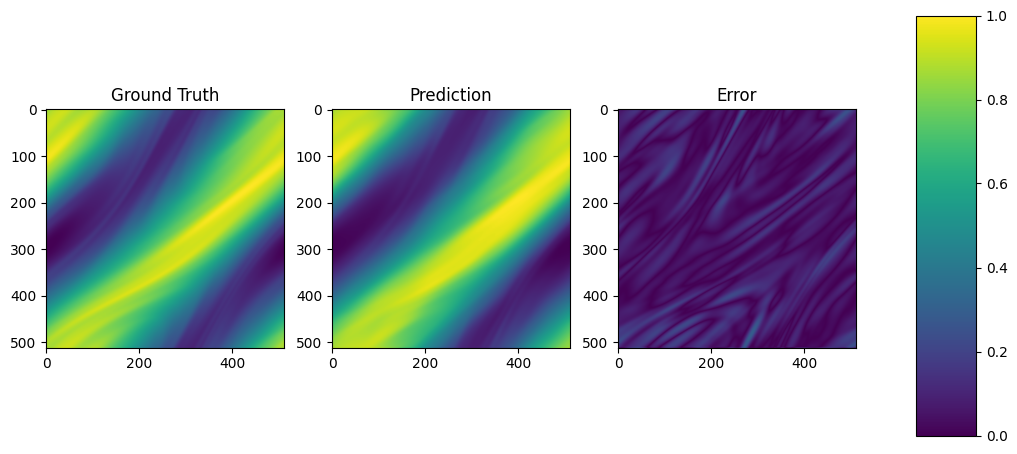

In [65]:
# Make animation with predictions
# pred_512 is [N, T, H, W], data_512 is [N, H, W, T]
import matplotlib.animation as animation

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(data_512[0, :, :, 10])
ax[0].set_title("Ground Truth")
ax[1].imshow(pred_512[0, 0, :, :].cpu().numpy())
ax[1].set_title("Prediction")
ax[2].imshow(data_512[0, :, :, 10] - pred_512[0, 0, :, :].cpu().numpy(), vmin=0, vmax=1)
ax[2].set_title("Error")

# Add colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(ax[2].imshow(data_512[0, :, :, 10] - pred_512[0, 0, :, :].cpu().numpy(), vmin=0, vmax=1), cax=cbar_ax)

def animate(i):
    ax[0].imshow(data_512[0, :, :, 10+i])
    ax[1].imshow(pred_512[0, i, :, :].cpu().numpy())
    ax[2].imshow(np.abs(data_512[0, :, :, 10+i] - pred_512[0, i, :, :].cpu().numpy()), vmin=0, vmax=1)
    
ani = animation.FuncAnimation(fig, animate, frames=10, interval=500)
ani.save("FNO_NavierStokes_super_resolution512_model64.gif")

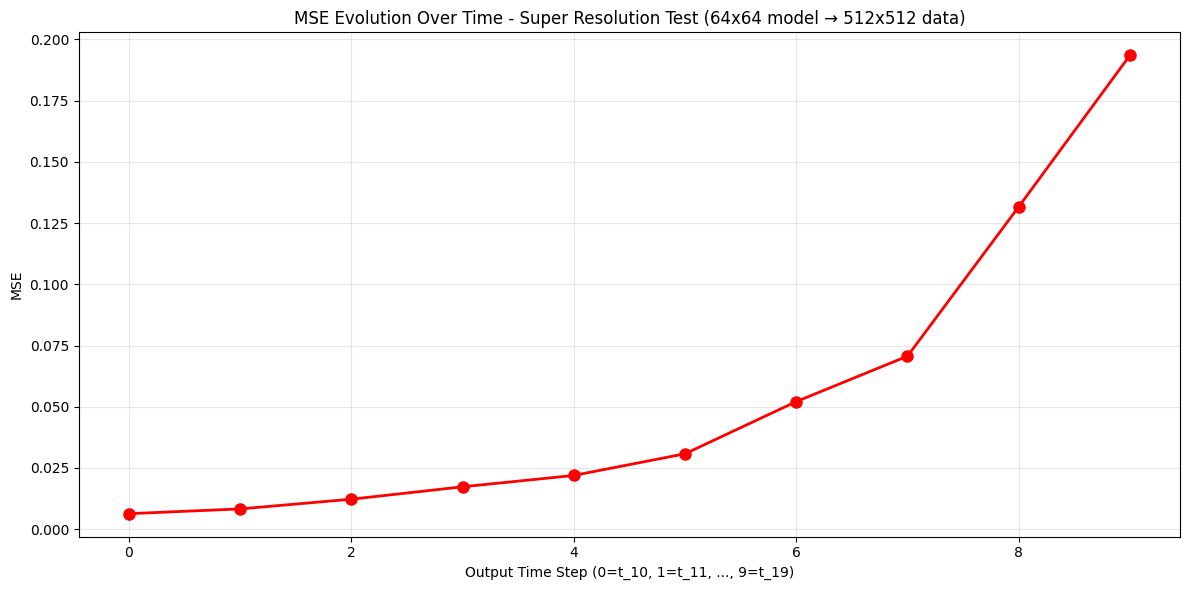

In [66]:
# Plot the error evolution over time
# pred_512 is [N, T, H, W], data_512 is [N, H, W, T]
error = []
for i in range(10):
    error.append(F.mse_loss(pred_512[0, i, :, :], torch.tensor(data_512[0, :, :, 10+i]).cuda()).item())
    
fig = plt.figure(figsize=(12, 6))
plt.plot(error, "o-", linewidth=2, markersize=8, color='red')
plt.xlabel("Output Time Step (0=t_10, 1=t_11, ..., 9=t_19)")
plt.ylabel("MSE")
plt.title("MSE Evolution Over Time - Super Resolution Test (64x64 model → 512x512 data)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()